In [104]:
import pandas as pd
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.simplefilter('ignore')
from sklearn.metrics.pairwise import euclidean_distances
import pyodbc

In [105]:
DB = {
    "servername" : r"VISSIE\SQLEXPRESS",
    "database" : "SDM"}

export_conn = pyodbc.connect(f"""DRIVER={'SQL SERVER'};
                             SERVER={DB['servername']};
                             DATABASE={DB['database']};
                             Trusted_Connection=yes
                             """)

export_conn.setencoding('utf-8')
export_conn.setdecoding(pyodbc.SQL_CHAR, encoding='utf-8')
export_conn.setdecoding(pyodbc.SQL_WCHAR, encoding='utf-8')

export_cursor = export_conn.cursor()

In [106]:
def create_dataframes_sql(connection, db_type : str):
    dictionary : dict = {}
    query : str = ""
    key : str = ""
    
    if (db_type == "sqlite"):
        query = "SELECT name FROM sqlite_master WHERE type='table';"
        key = "name"
    elif (db_type == "ssms"):
        query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE';"
        key = "TABLE_NAME"
    else:
        return {}
    table_names = pd.read_sql(query, connection)
    
    for table in table_names[key].tolist():
        dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)
    
    return dictionary

sdm = create_dataframes_sql(export_conn, "ssms")

In [107]:
orders = sdm["order_details"]

orders_specfic = orders[["QUANTITY", "UNIT_COST", "UNIT_PRICE", "UNIT_SALE_PRICE", "ORDER_NUMBER"]]
orders_specfic["TOTAL_COSTS"] = orders["QUANTITY"] * orders["UNIT_COST"]
orders_specfic["REVENUE"] = orders["QUANTITY"] * orders["UNIT_SALE_PRICE"]
orders_specfic["PROFIT"] = (orders["UNIT_PRICE"] * orders["QUANTITY"]) - orders_specfic["TOTAL_COSTS"]

frame = pd.merge(sdm["sales_branch"], sdm["order_header"], left_on="SALES_BRANCH_CODE", right_on="SALES_BRANCH_CODE")
frame = pd.merge(frame, sdm["order_details"], left_on="ORDER_NUMBER", right_on="ORDER_NUMBER")
frame = pd.merge(frame, sdm["product"], left_on="PRODUCT_NUMBER", right_on="PRODUCT_NUMBER")
frame = pd.merge(frame, sdm["country"], left_on="COUNTRY_CODE", right_on="COUNTRY_CODE", suffixes=("", "_drop"))
#frame = pd.merge(frame, orders_specfic, left_on="ORDER_NUMBER", right_on="ORDER_NUMBER", suffixes=("", "_drop"))

frame = frame[[col for col in frame.columns if not col.endswith("_drop")]]

frame = frame[frame["REGION"].notna()]

frame = frame[["SALES_BRANCH_CODE", "CITY", "REGION", "COUNTRY", "QUANTITY", "PRODUCT_NAME", "UNIT_SALE_PRICE"]]
frame

,SALES_BRANCH_CODE,CITY,REGION,COUNTRY,QUANTITY,PRODUCT_NAME,UNIT_SALE_PRICE
3193,9,Amsterdam,Noord-Holland,Netherlands,26,Hibernator Extreme,265.14
3194,9,Amsterdam,Noord-Holland,Netherlands,18,Hibernator Pad,40.65
3195,9,Amsterdam,Noord-Holland,Netherlands,58,Bear Survival Edge,92.29
3196,9,Amsterdam,Noord-Holland,Netherlands,24,Seeker Extreme,182.67
3197,9,Amsterdam,Noord-Holland,Netherlands,30,Glacier Deluxe,96.44
...,...,...,...,...,...,...,...
33758,36,Birmingham,West Midlands,United Kingdom,38,Mountain Man Extreme,255.07
33759,36,Birmingham,West Midlands,United Kingdom,46,Edge Extreme,115.84
33760,36,Birmingham,West Midlands,United Kingdom,48,Bear Survival Edge,90.63
33761,36,Birmingham,West Midlands,United Kingdom,16,Glacier GPS Extreme,301.20


In [108]:
#frame["SALES_BRANCH_CODE"] = frame["SALES_BRANCH_CODE"].astype(str)
frame.dtypes

SALES_BRANCH_CODE      int64
CITY                  object
REGION                object
COUNTRY               object
QUANTITY               int64
PRODUCT_NAME          object
UNIT_SALE_PRICE      float64
dtype: object

In [109]:
dummies_city = pd.get_dummies(frame.loc[:, ["CITY", "COUNTRY", "REGION"]])
dummies_city

,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,CITY_Distrito Federal,CITY_Los Angeles,CITY_Melbourne,CITY_Miami,CITY_Osaka City,...,REGION_Noord-Holland,REGION_Ontario,REGION_Osaka,REGION_SP,REGION_Taipei,REGION_Tokyo,REGION_VIC,REGION_Vizcaya,REGION_Washington,REGION_West Midlands
3193,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3194,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3195,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3196,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3197,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33758,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
33759,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
33760,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
33761,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [110]:
frame_2 = frame[["QUANTITY", "SALES_BRANCH_CODE"]]

frame_2


,QUANTITY,SALES_BRANCH_CODE
3193,26,9
3194,18,9
3195,58,9
3196,24,9
3197,30,9
...,...,...
33758,38,36
33759,46,36
33760,48,36
33761,16,36


In [111]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit_predict(frame_2)

array([0, 0, 0, ..., 0, 0, 0], shape=(19822,), dtype=int32)

In [112]:
kmeans.cluster_centers_

array([[ 31.57026076,  22.02345009],
       [407.91891892,  24.52364865],
       [131.14998193,  22.04228406]])

In [113]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

,0,1
0,31.570261,22.023450
1,407.918919,24.523649
2,131.149982,22.042284


In [114]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{frame_2.columns[i]}'})
    
kmeans_centra

,QUANTITY,SALES_BRANCH_CODE
0,31.570261,22.023450
1,407.918919,24.523649
2,131.149982,22.042284


In [115]:
for src_index, _ in frame_2.iterrows():
    euclidian_distances = dict()
    #print(f"Afstand van bronindex {src_index} tot...")
    
    for centrumindex, _ in kmeans_centra.iterrows():
        #print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = frame_2.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            #print(f'\t\t{frame_2.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        #print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        #print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        #print('------------------------------------------------')
    
    #print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    #print(centrum_number)
    frame_2.at[src_index, 'Centrum'] = centrum_number
    #print("================================================")

frame_2

,QUANTITY,SALES_BRANCH_CODE,Centrum
3193,26,9,0.0
3194,18,9,0.0
3195,58,9,0.0
3196,24,9,0.0
3197,30,9,0.0
...,...,...,...
33758,38,36,0.0
33759,46,36,0.0
33760,48,36,0.0
33761,16,36,0.0


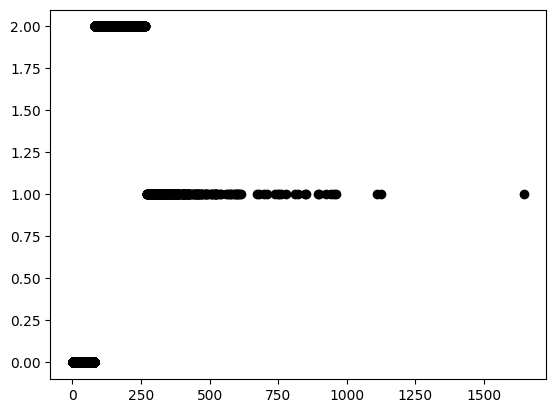

In [116]:
plt.scatter(frame_2['QUANTITY'], frame_2['Centrum'], color = 'k')
plt.show()

In [117]:
frame_2.groupby('Centrum', as_index = False)['Centrum'].count()

frame.dtypes

SALES_BRANCH_CODE      int64
CITY                  object
REGION                object
COUNTRY               object
QUANTITY               int64
PRODUCT_NAME          object
UNIT_SALE_PRICE      float64
dtype: object

In [118]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
prediction_results = kmeans.fit_predict(dummies)
prediction_results

array([2, 2, 2, ..., 1, 1, 1], shape=(19822,), dtype=int32)

In [119]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)

#Interclusterafstanden weergeven.
#Intraclusterafstanden: zelf ChatGPT'en
dists = euclidean_distances(kmeans.cluster_centers_)
pd.DataFrame(dists)

,0,1,2,3,4,5
0,0.000000,5.329211,4.060574,3.856383,3.425533,5.725462
1,5.329211,0.000000,4.531527,3.303242,5.078630,3.856125
2,4.060574,4.531527,0.000000,3.316766,4.226548,4.791069
3,3.856383,3.303242,3.316766,0.000000,3.776284,3.366494
4,3.425533,5.078630,4.226548,3.776284,0.000000,5.310238
5,5.725462,3.856125,4.791069,3.366494,5.310238,0.000000


In [120]:
frame['Centrum'] = prediction_results
frame

,SALES_BRANCH_CODE,CITY,REGION,COUNTRY,QUANTITY,PRODUCT_NAME,UNIT_SALE_PRICE,Centrum
3193,9,Amsterdam,Noord-Holland,Netherlands,26,Hibernator Extreme,265.14,2
3194,9,Amsterdam,Noord-Holland,Netherlands,18,Hibernator Pad,40.65,2
3195,9,Amsterdam,Noord-Holland,Netherlands,58,Bear Survival Edge,92.29,2
3196,9,Amsterdam,Noord-Holland,Netherlands,24,Seeker Extreme,182.67,2
3197,9,Amsterdam,Noord-Holland,Netherlands,30,Glacier Deluxe,96.44,2
...,...,...,...,...,...,...,...,...
33758,36,Birmingham,West Midlands,United Kingdom,38,Mountain Man Extreme,255.07,1
33759,36,Birmingham,West Midlands,United Kingdom,46,Edge Extreme,115.84,1
33760,36,Birmingham,West Midlands,United Kingdom,48,Bear Survival Edge,90.63,1
33761,36,Birmingham,West Midlands,United Kingdom,16,Glacier GPS Extreme,301.20,1


In [121]:
frame.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,7101
1,1468
2,2514
3,5288
4,1135
5,2316
